In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from struct import unpack_from
import struct
import py4DSTEM
from scipy.ndimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening

from py4DSTEM.process.preprocess import get_darkreference
from py4DSTEM.process.preprocess import get_bksbtr_DP
from py4DSTEM.process.preprocess import electron_count

In [2]:
headersize = 4
pixelsize = 2
R_Nx,R_Ny,Q_Nx,Q_Ny = 40,40,576,576
size = np.prod((R_Nx,R_Ny,Q_Nx,Q_Ny))
frame_size = np.prod((Q_Nx,Q_Ny))

In [34]:
fp = "/home/ben/Data/20190311_Bullseye_newcamera_forElectronCounting/20190220_80kV/scan_0000000235_darkref/stem4d_0000000235_0000000000.dat"
f = open(fp, 'rb')
f.seek(headersize)

4

In [4]:
data = struct.unpack_from('<{}H'.format(size), f.read(2*size))
data = np.array(data).reshape((R_Nx,R_Ny,Q_Nx,Q_Ny))

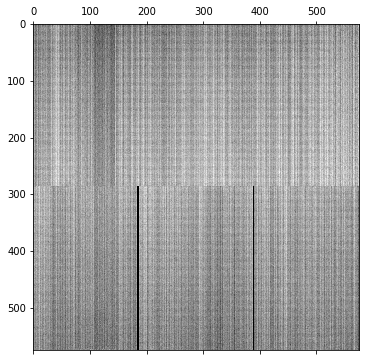

In [5]:
fig,ax = plt.subplots(figsize=(6,6))
ax.matshow(data[0,0,:,:])
plt.show()

In [6]:
darkref = np.median(data,axis=(0,1))

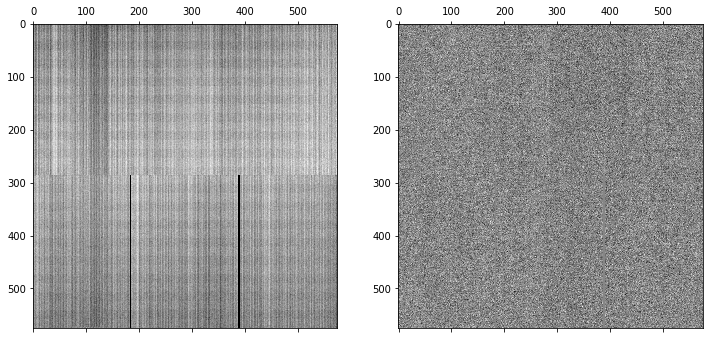

In [7]:
DP = data[20,20,:,:]
power=1

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(darkref**power)
ax2.matshow((DP-darkref)**power)
plt.show()

In [35]:
fp = "/home/ben/Data/20190311_Bullseye_newcamera_forElectronCounting/20190220_80kV/scan_0000000236_logo/stem4d_0000000236_0000000000.dat"
f = open(fp, 'rb')
f.seek(headersize)

4

In [36]:
data = struct.unpack_from('<{}H'.format(size), f.read(2*size))
data = np.array(data).reshape((R_Nx,R_Ny,Q_Nx,Q_Ny))

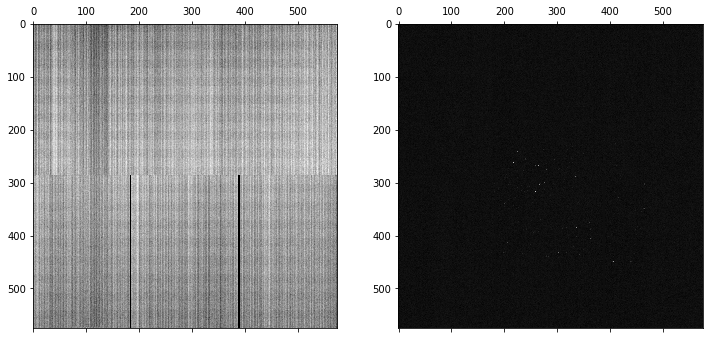

In [37]:
DP = data[20,20,:,:]
power=1

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(darkref**power)
ax2.matshow((DP-darkref)**power)
plt.show()

In [38]:
Nsamples = 40
thresh_bkgrnd_Nsigma = 4
thresh_xray_Nsigma = 30
binfactor = 1
sub_pixel = False
output = 'datacube'

counted_data = electron_count(data, darkref.astype(np.int16), Nsamples=Nsamples,
                              thresh_bkgrnd_Nsigma=thresh_bkgrnd_Nsigma,
                              thresh_xray_Nsigma=thresh_xray_Nsigma,
                              binfactor=binfactor,
                              sub_pixel=sub_pixel,
                              output=output)

Calculating threshholds


In [39]:
all_counts_1dc = np.sum(counted_data,axis=(0,1))

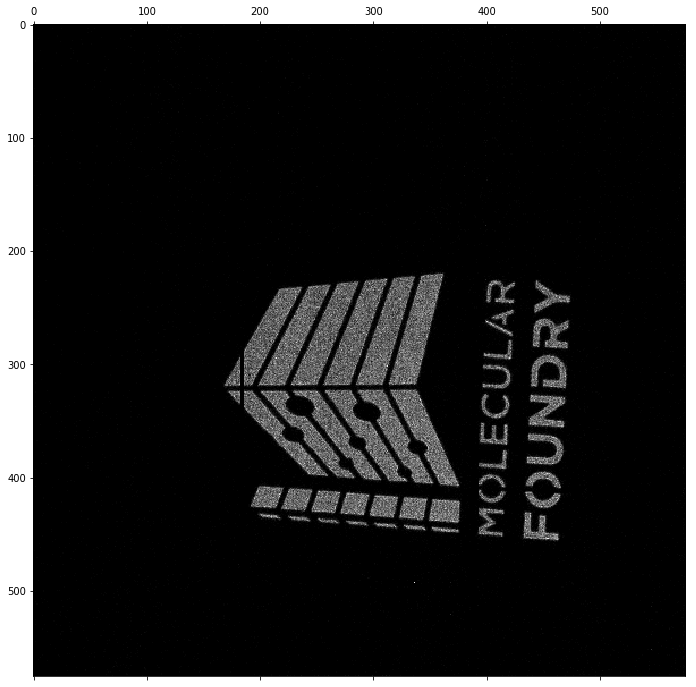

In [40]:
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(all_counts_1dc)
plt.show()

#### Run for all data

In [30]:
Nsamples = 40
thresh_bkgrnd_Nsigma = 4
thresh_xray_Nsigma = 30
binfactor = 1
sub_pixel = False
output = 'datacube'

directory_path = "/home/ben/Data/20190311_Bullseye_newcamera_forElectronCounting/20190220_80kV/scan_0000000236_logo/"
files = os.listdir(directory_path)
files.remove('stem4d_0000000236_0000000012.dat')

all_counts = np.zeros((Q_Nx,Q_Ny))

for filename in files:
    print('Analyzing file {}...'.format(filename))
    fp = directory_path + filename
    f = open(fp, 'rb')
    f.seek(headersize)
    data = struct.unpack_from('<{}H'.format(size), f.read(2*size))
    data = np.array(data).reshape((R_Nx,R_Ny,Q_Nx,Q_Ny))
    
    counted_data = electron_count(data, darkref.astype(np.int16), Nsamples=Nsamples,
                              thresh_bkgrnd_Nsigma=thresh_bkgrnd_Nsigma,
                              thresh_xray_Nsigma=thresh_xray_Nsigma,
                              binfactor=binfactor,
                              sub_pixel=sub_pixel,
                              output=output)
    
    all_counts += np.sum(counted_data,axis=(0,1))

Analyzing file stem4d_0000000236_0000000004.dat...
Calculating threshholds
Analyzing file stem4d_0000000236_0000000002.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000007.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000001.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000005.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000000.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000011.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000003.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000008.dat...**********--| 97.6% Complete
Calculating threshholds
Analyzing file stem4d_0000000236_0000000006.dat...**********--| 97.6% Complete
Calculating threshhold

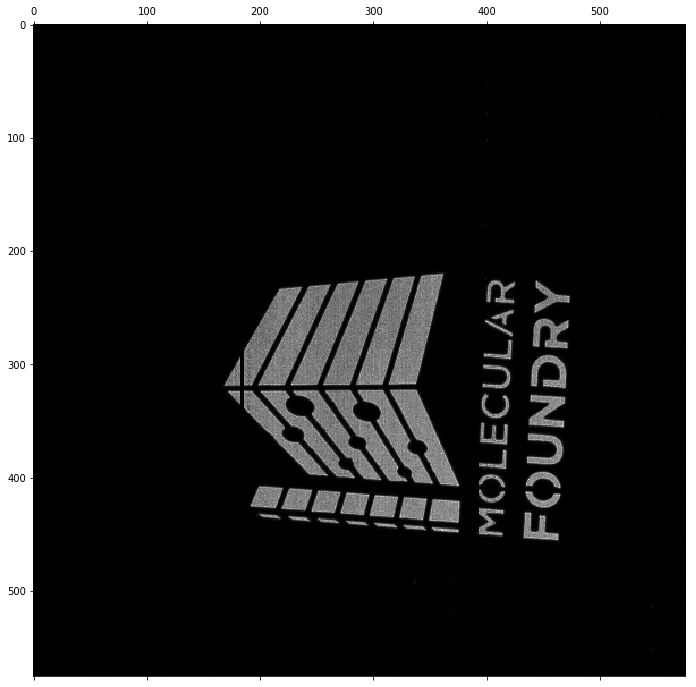

In [31]:
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(all_counts)
plt.show()

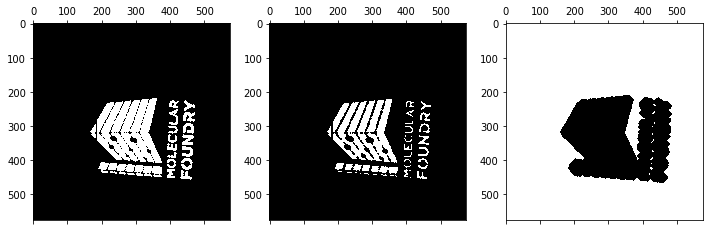

In [32]:
mask = all_counts>10
mask = binary_opening(mask, iterations=1)
mask = binary_closing(mask, iterations=1)
mask_in = binary_erosion(mask,iterations=2)
mask_out = binary_dilation(mask,iterations=10)==0

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,12))
ax1.matshow(mask)
ax2.matshow(mask_in)
ax3.matshow(mask_out)
plt.show()

In [33]:
# Counts per pixel per frame

counts_in = np.sum(all_counts[mask_in])/(np.sum(mask_in))/(len(files)*1600)
counts_out = np.sum(all_counts[mask_out])/(np.sum(mask_out))/(len(files)*1600)

print("Mean counts per pixel per frame:")
print("Inside logo: {}".format(counts_in))
print("Out of logo: {}".format(counts_out))
print("Ratio: {}".format(counts_in/counts_out))

Mean counts per pixel per frame:
Inside logo: 0.009225308129232326
Out of logo: 1.308226471837757e-05
Ratio: 705.1766898030195


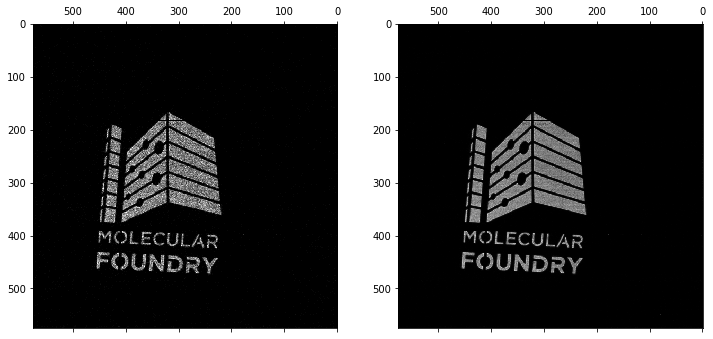

In [49]:
vmin,vmax = 0,30

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
cax = ax1.matshow(all_counts_1dc.T,vmin=vmin,vmax=vmax)
ax2.matshow(all_counts.T/len(files),vmin=vmin,vmax=vmax)
ax1.invert_xaxis()
ax2.invert_xaxis()
#plt.colorbar(cax)
plt.show()